In [1]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Read ORF and CRISPR cosine similarities

orf_similarity_df = pd.read_parquet('cos_sim/cosine_similarities_genes_orf.parquet')
crispr_similarity_df = pd.read_parquet('cos_sim/cosine_similarities_genes_crispr.parquet')

In [3]:
def check_connections(
    genes,
    orf_similarity_df,
    crispr_similarity_df,
    connections_df,
):
    genes.sort()
    for i in range(len(genes) - 1):
        gene_1 = genes[i]
        for j in range(i + 1, len(genes)):
            gene_2 = genes[j]
            df = pd.DataFrame(
                {
                    "gene_1": gene_1,
                    "gene_2": gene_2,
                    "Present_and_replicable_in_ORF": False,
                    "ORF_cosine_similarity": np.nan,
                    "Present_and_replicable_in_CRISPR": False,
                    "CRISPR_cosine_similarity": np.nan,
                },
                index=[0],
            )
            if (
                gene_1 in orf_similarity_df.index
                and gene_2 in orf_similarity_df.columns
            ):
                df["Present_and_replicable_in_ORF"] = True
                df["ORF_cosine_similarity"] = orf_similarity_df.loc[gene_1, gene_2]
            if (
                gene_1 in crispr_similarity_df.index
                and gene_2 in crispr_similarity_df.columns
            ):
                df["Present_and_replicable_in_CRISPR"] = True
                df["CRISPR_cosine_similarity"] = crispr_similarity_df.loc[
                    gene_1, gene_2
                ]

            connections_df = pd.concat([connections_df, df], ignore_index=True, axis=0)

    connections_df.drop_duplicates(
        subset=["gene_1", "gene_2"], inplace=True, keep="first"
    )

    return connections_df

In [4]:
connections_df = pd.DataFrame()
signal_threshold = 0.4

Check previous connections that we were interested in

In [5]:
previous_gene_lists = [
    ["ZBTB16", "SLC39A1"],
    ["RAB30", "NAT14"],
    ["MYT1", "RNF41", "INSYN1"],
    ["PIK3R3", "RAB40A", "RAB40B", "RAB40C", "INSYN1", "XLOC_l2_008134"],
    ["BICD2", "HOOK1", "HOOK2", "SPDL1", "NDEL1", "NDE1", "PAFAH1B1"],
    ["TRAF2", "STK3", "YAP1", "WWTR1", "STK11"],
    ["GPR176", "TSC22D1", "DPAT1", "CHRM4", "CDC42SE2", "CDC25C", "MYT1", "MAP4K4"],
    ["ECH1", "UQCRFS1", "SARS2"],
    ["POLRID", "SPATA25", "CAMK2A", "GJB2", "ATG7", "MGLL", "CCL14", "PNPLA4", "EML1", "PER1", "SLC39A1"],
    ["FOXO3", "TGFB1"]
]

In [6]:
for genes in previous_gene_lists:
    previous = True
    connections_df = check_connections(genes, orf_similarity_df, crispr_similarity_df, connections_df)

Add all knowledge graph information

In [7]:
knowledge_graph_orf = pd.read_csv(
    "~/Downloads/orf_scores_merged.zip",
    sep="\t",
    usecols=["GENE1", "GENE2", "gene_mf__go", "gene_bp__go", "gene_pathway"],
).rename(
    columns={
        "GENE1": "gene_1",
        "GENE2": "gene_2",
        "gene_mf__go": "gene_mf",
        "gene_bp__go": "gene_bp",
    }
)

knowledge_graph_orf = pd.concat(
    [
        knowledge_graph_orf,
        knowledge_graph_orf.rename(columns={"gene_1": "gene_2", "gene_2": "gene_1"}),
    ],
    ignore_index=True,
)

knowledge_graph_crispr = pd.read_csv(
    "~/Downloads/crispr_scores_merged.zip",
    sep="\t",
    usecols=["GENE1", "GENE2", "gene_mf__go", "gene_bp__go", "gene_pathway"],
).rename(
    columns={
        "GENE1": "gene_1",
        "GENE2": "gene_2",
        "gene_mf__go": "gene_mf",
        "gene_bp__go": "gene_bp",
    }
)

knowledge_graph_crispr = pd.concat(
    [
        knowledge_graph_crispr,
        knowledge_graph_crispr.rename(columns={"gene_1": "gene_2", "gene_2": "gene_1"}),
    ],
    ignore_index=True,
)

knowledge_graph = pd.concat(
    [knowledge_graph_orf, knowledge_graph_crispr], ignore_index=True
).drop_duplicates(subset=["gene_1", "gene_2"])

connections_df = connections_df.merge(
    knowledge_graph, on=["gene_1", "gene_2"], how="left"
)

Determine if there is evidence in each data type

In [8]:
connections_df["Evidence_in_ORF"] = np.where(np.abs(connections_df["ORF_cosine_similarity"]) > signal_threshold, True, False)
connections_df["Evidence_in_CRISPR"] = np.where(np.abs(connections_df["CRISPR_cosine_similarity"]) > signal_threshold, True, False)
connections_df["Evidence_in_Knowledge_Graph"] = (connections_df[["gene_mf", "gene_bp", "gene_pathway"]].abs() > signal_threshold).any(axis=1)

In [9]:
with pd.ExcelWriter("output/connections.xlsx") as writer:
    connections_df.to_excel(writer, index=False, sheet_name="all_connections")

Filter out rows where the knowledge graph information is not available

In [10]:
connections_df_knowledge_graph = connections_df.query("gene_mf.notna() and gene_bp.notna() and gene_pathway.notna()").reset_index(drop=True)

Connections that are present in either ORFs or CRISPRs or both

In [11]:
with pd.ExcelWriter("output/connections.xlsx", mode="a") as writer:
    connections_df[
        connections_df[["Evidence_in_ORF", "Evidence_in_CRISPR"]].any(axis=1)
    ].reset_index(drop=True).to_excel(
        writer, index=False, sheet_name="connections_present"
    )

Connections that are not present in either ORFs or CRISPRs

In [12]:
with pd.ExcelWriter("output/connections.xlsx", mode="a") as writer:
    connections_df[
        ~connections_df[["Evidence_in_ORF", "Evidence_in_CRISPR"]].any(axis=1)
    ].reset_index(drop=True).to_excel(
        writer, index=False, sheet_name="connections_not_present"
    )

Connections that are present in ORFs or CRISPRs with evidence in knowledge graph

In [13]:
with pd.ExcelWriter("output/connections.xlsx", mode="a") as writer:
    connections_df_knowledge_graph[
        connections_df_knowledge_graph[["Evidence_in_ORF", "Evidence_in_CRISPR"]].any(
            axis=1
        )
    ].query("Evidence_in_Knowledge_Graph==True").reset_index(drop=True).to_excel(
        writer, index=False, sheet_name="connections_known"
    )

Connections that are present in ORFs or CRISPRs without evidence in knowledge graph

In [14]:
with pd.ExcelWriter("output/connections.xlsx", mode="a") as writer:
    connections_df_knowledge_graph[
        connections_df_knowledge_graph[["Evidence_in_ORF", "Evidence_in_CRISPR"]].any(
            axis=1
        )
    ].query("Evidence_in_Knowledge_Graph==False").reset_index(drop=True).to_excel(
        writer, index=False, sheet_name="connection_unknown"
    )

Connections that are present in both ORFs and CRISPRs

In [15]:
with pd.ExcelWriter("output/connections.xlsx", mode="a") as writer:
    connections_df[
        connections_df[["Evidence_in_ORF", "Evidence_in_CRISPR"]].all(axis=1)
    ].reset_index(drop=True).to_excel(
        writer, index=False, sheet_name="connections_present_both"
    )

Connections that are present in both ORFs and CRISPRs with evidence in knowledge graph

In [16]:
with pd.ExcelWriter("output/connections.xlsx", mode="a") as writer:
    connections_df_knowledge_graph[
        connections_df_knowledge_graph[["Evidence_in_ORF", "Evidence_in_CRISPR"]].all(
            axis=1
        )
    ].query("Evidence_in_Knowledge_Graph==True").reset_index(drop=True).to_excel(
        writer, index=False, sheet_name="connections_present_both_known"
    )

Connections that are present in both ORFs and CRISPRs without evidence in knowledge graph

In [17]:
with pd.ExcelWriter("output/connections.xlsx", mode="a") as writer:
    connections_df_knowledge_graph[
        connections_df_knowledge_graph[["Evidence_in_ORF", "Evidence_in_CRISPR"]].all(
            axis=1
        )
    ].query("Evidence_in_Knowledge_Graph==False").reset_index(drop=True).to_excel(
        writer, index=False, sheet_name="connections_present_both_unknown"
    )

/home/niranj/miniforge3/envs/similarity/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


YAP1 connections

In [18]:
print(orf_similarity_df.query("YAP1 > @signal_threshold or YAP1 < -@signal_threshold")["YAP1"].to_markdown())

|        |     YAP1 |
|:-------|---------:|
| WWTR1  | 0.528834 |
| PLS3   | 0.429233 |
| CORO2B | 0.466192 |
| CORO2A | 0.558896 |
| RTKN   | 0.422219 |
| CNN1   | 0.476689 |
| PRKCE  | 0.452393 |
| SYT2   | 0.405234 |
| SYT1   | 0.406036 |
| YAP1   | 1        |
| ZNF704 | 0.544696 |


In [19]:
print(orf_similarity_df.query("HOOK2 < -@signal_threshold")["HOOK2"].to_markdown())

|          |     HOOK2 |
|:---------|----------:|
| NDEL1    | -0.614541 |
| ST3GAL4  | -0.413381 |
| PLAU     | -0.42775  |
| NDE1     | -0.6563   |
| PURG     | -0.440695 |
| PDILT    | -0.414814 |
| PAFAH1B1 | -0.610536 |


In [20]:
print(orf_similarity_df.query("NDE1 < -@signal_threshold")["NDE1"].to_markdown())

|          |      NDE1 |
|:---------|----------:|
| NIN      | -0.427946 |
| HOOK2    | -0.6563   |
| ATCAY    | -0.532888 |
| PAFAH1B3 | -0.530362 |
| CRACR2B  | -0.532522 |
| NEK9     | -0.412943 |
| PAFAH1B2 | -0.585289 |
| FAM114A1 | -0.436914 |
| TGIF2LX  | -0.430285 |
| HOOK1    | -0.589538 |


In [21]:
print(orf_similarity_df.query("NDEL1 < -@signal_threshold")["NDEL1"].to_markdown())

|          |     NDEL1 |
|:---------|----------:|
| NIN      | -0.418717 |
| HOOK2    | -0.614541 |
| ATCAY    | -0.490127 |
| PAFAH1B3 | -0.484632 |
| CRACR2B  | -0.513532 |
| NEK9     | -0.40055  |
| PAFAH1B2 | -0.514465 |
| FAM114A1 | -0.419338 |
| HOOK1    | -0.532928 |


In [22]:
print(orf_similarity_df.query("PAFAH1B1 < -@signal_threshold")["PAFAH1B1"].to_markdown())

|          |   PAFAH1B1 |
|:---------|-----------:|
| HOOK2    |  -0.610536 |
| ATCAY    |  -0.450775 |
| CRACR2B  |  -0.474904 |
| NEK9     |  -0.421749 |
| PAFAH1B2 |  -0.416855 |
| FAM114A1 |  -0.435566 |
| HOOK1    |  -0.473261 |


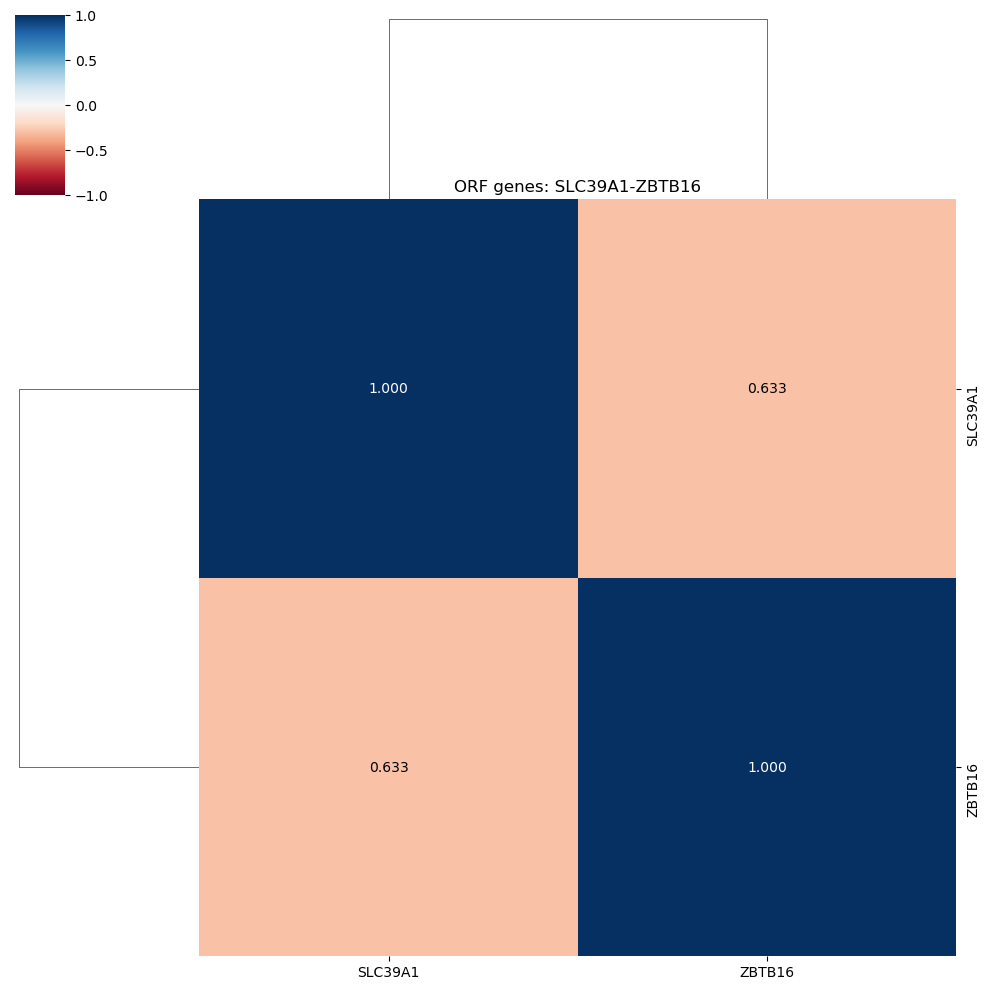

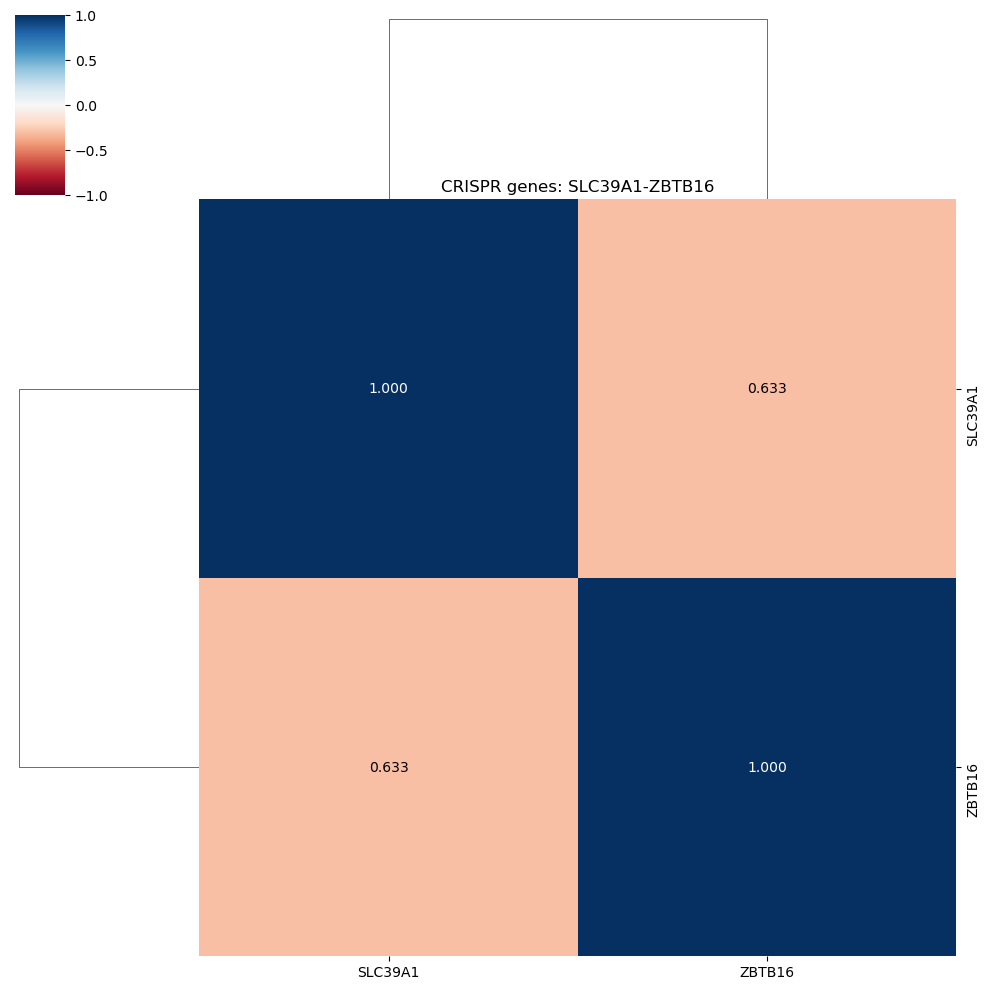

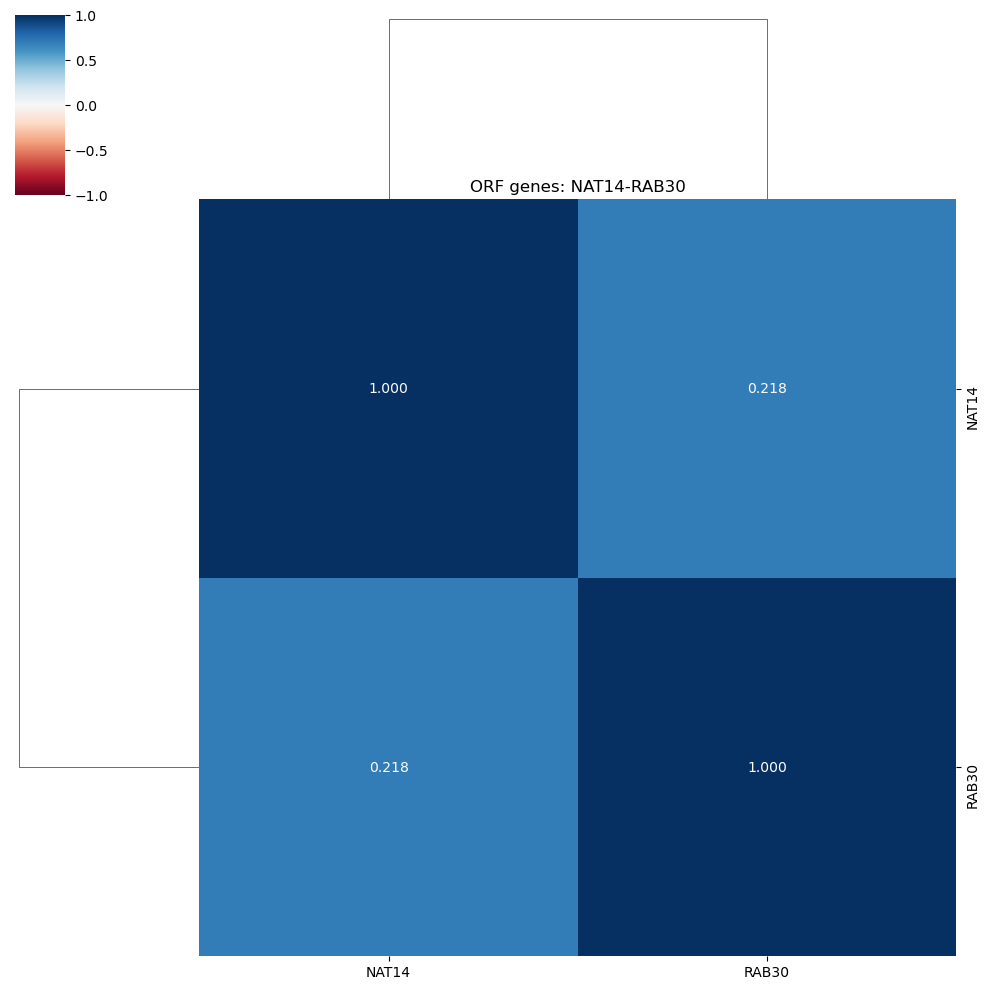

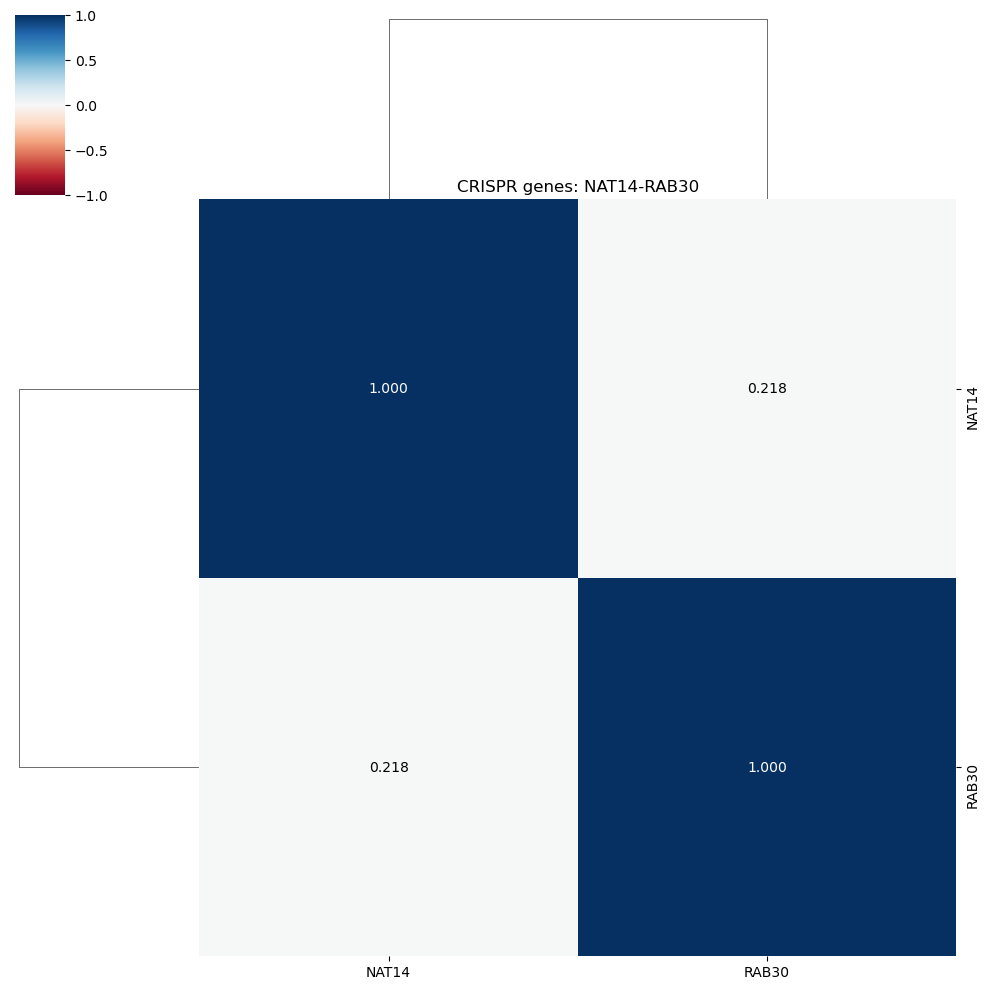

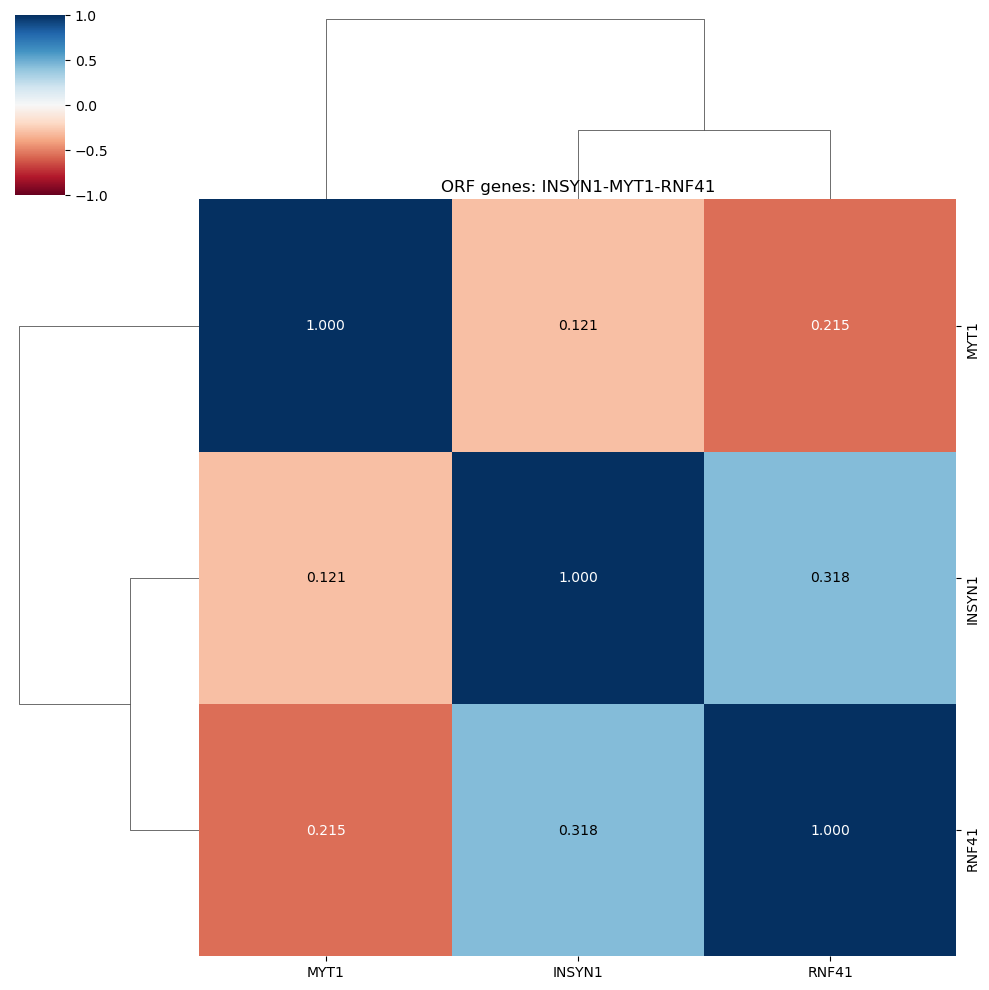

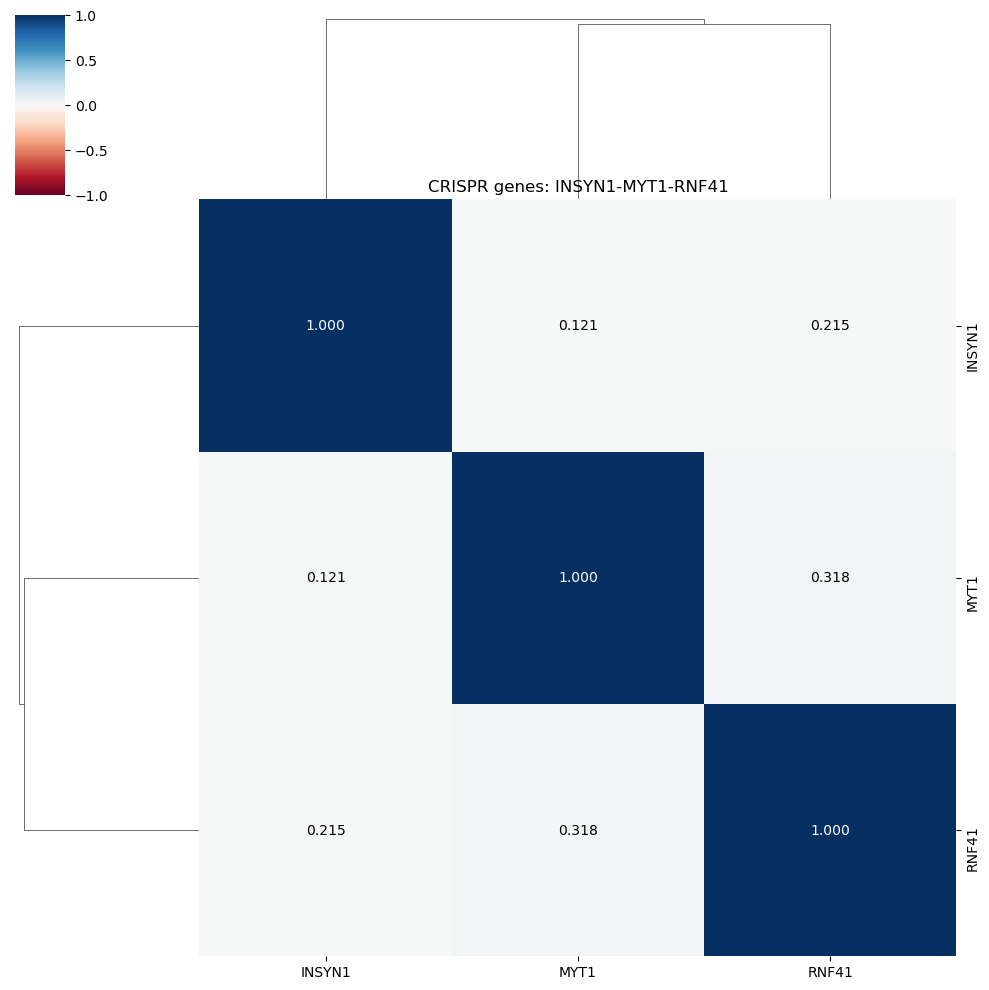

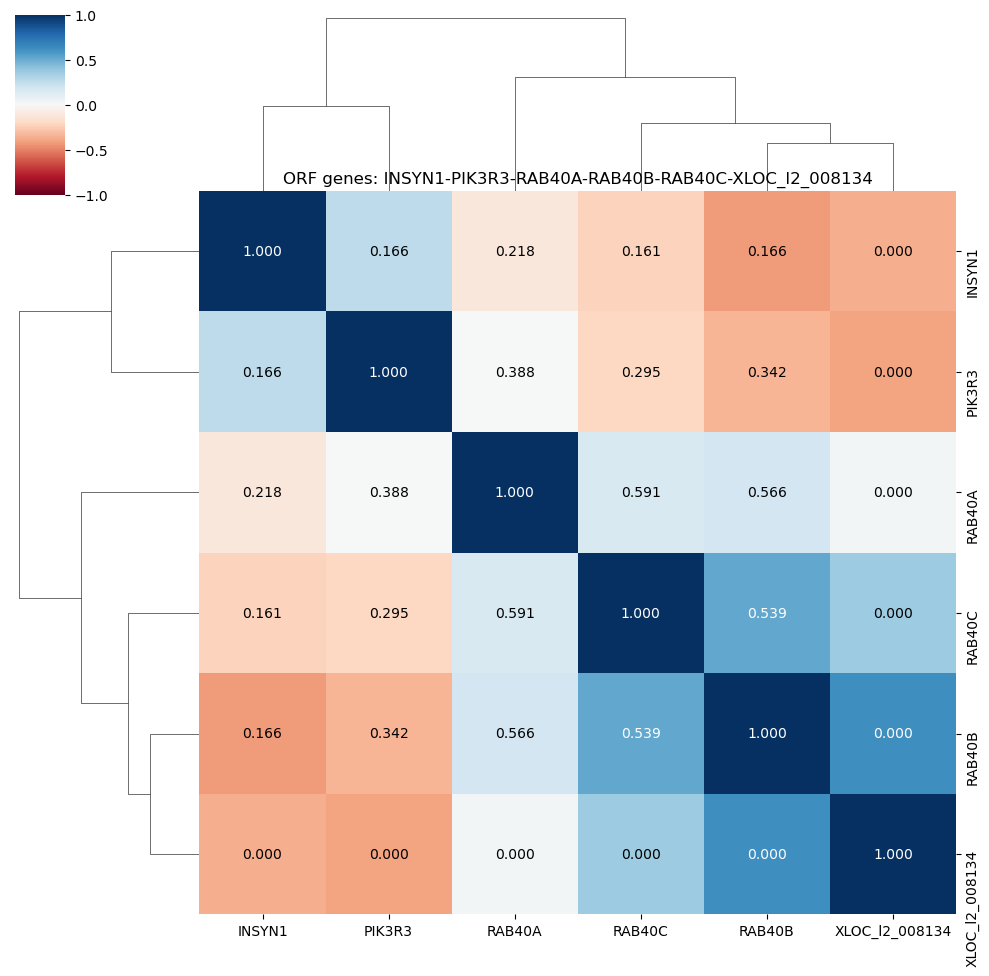

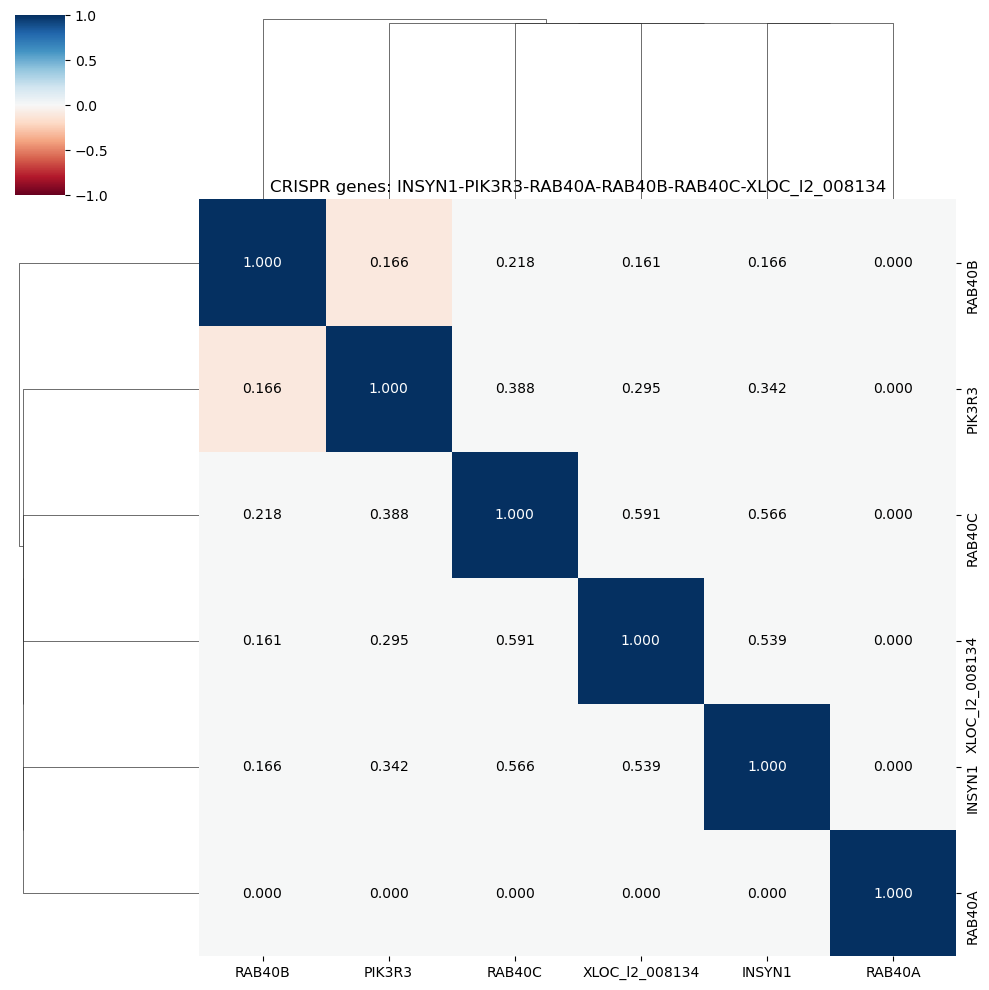

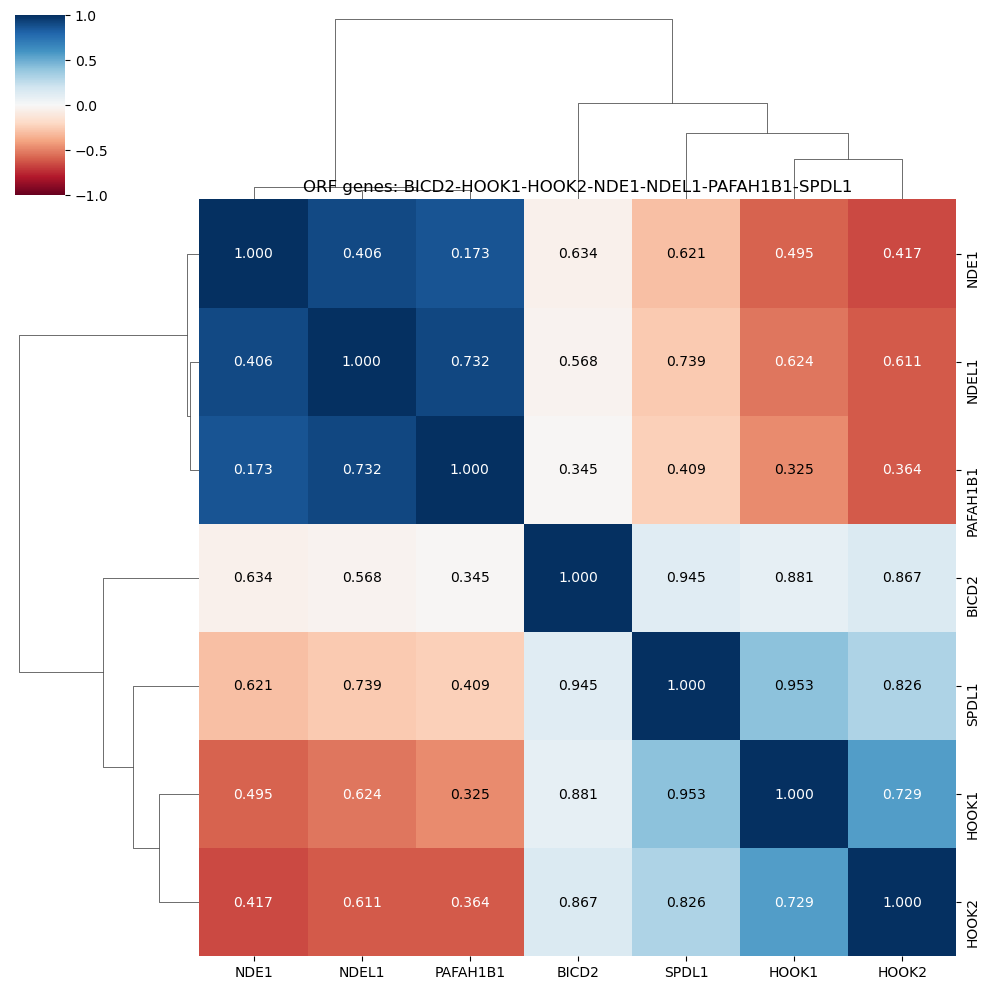

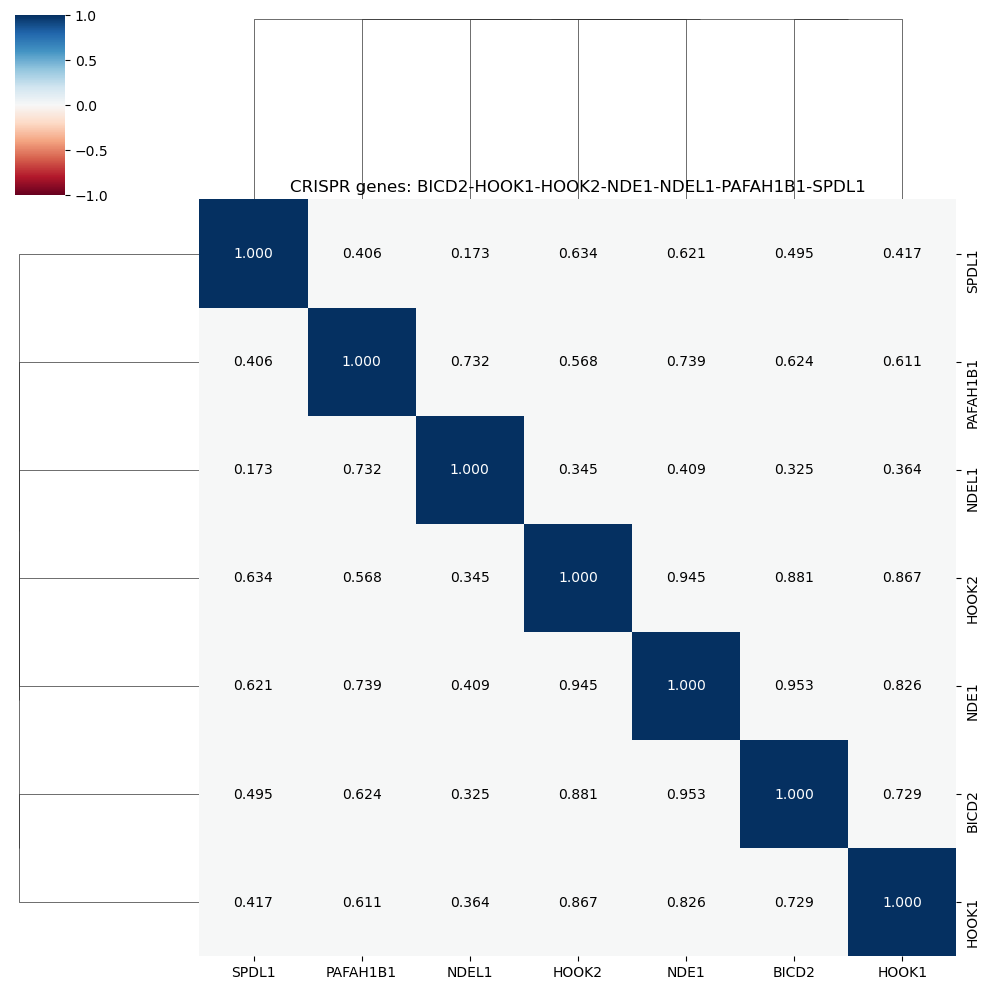

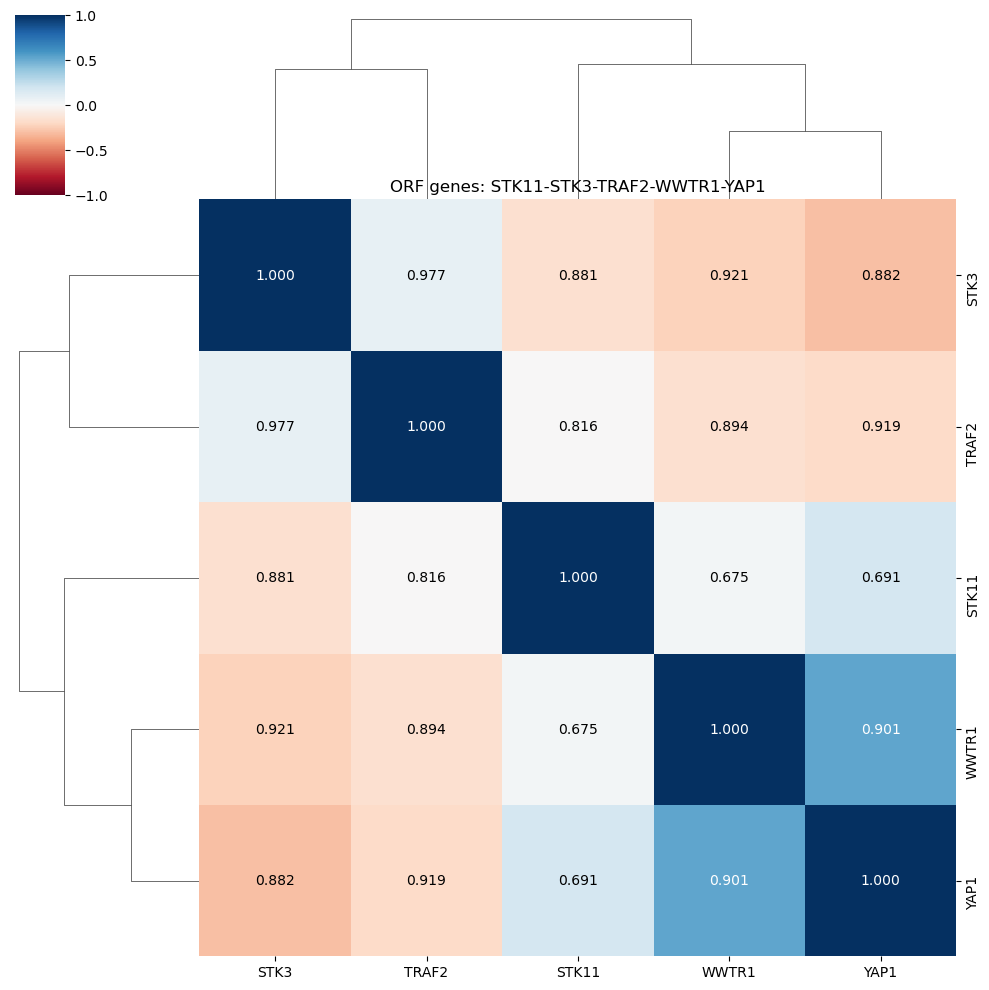

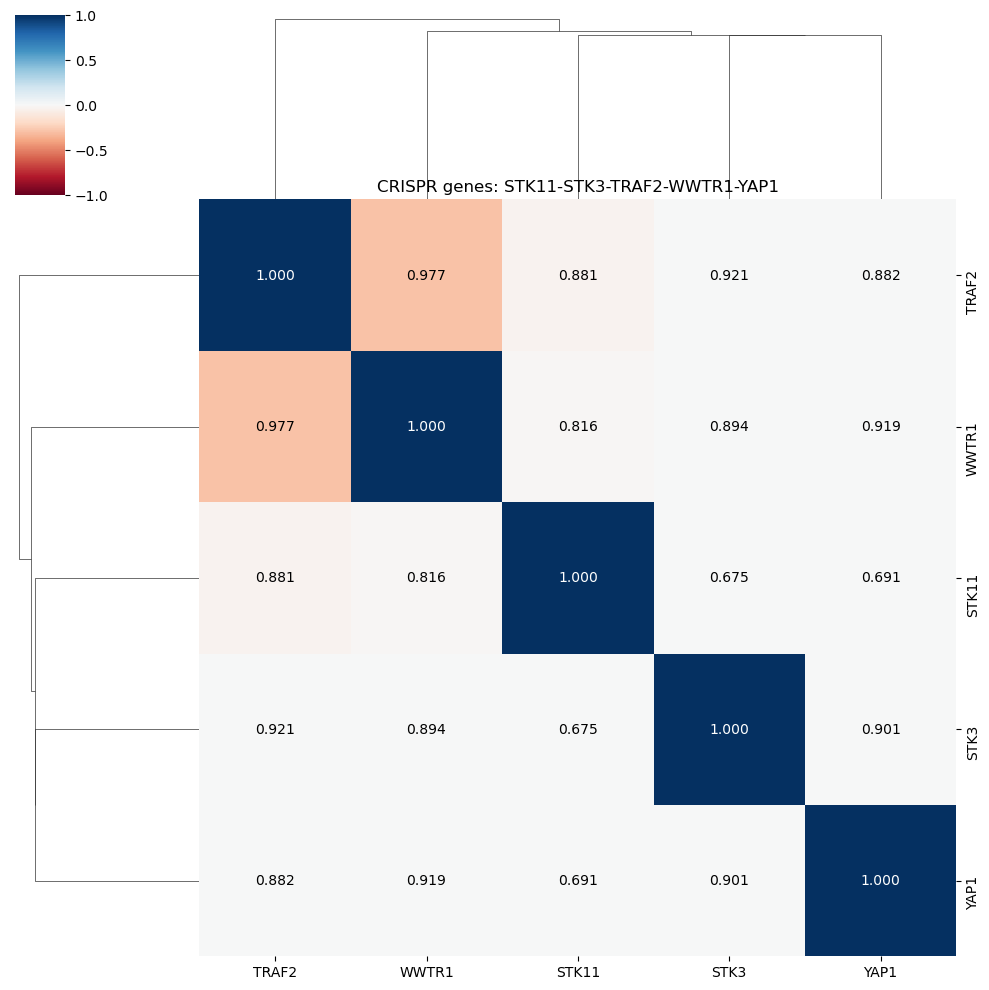

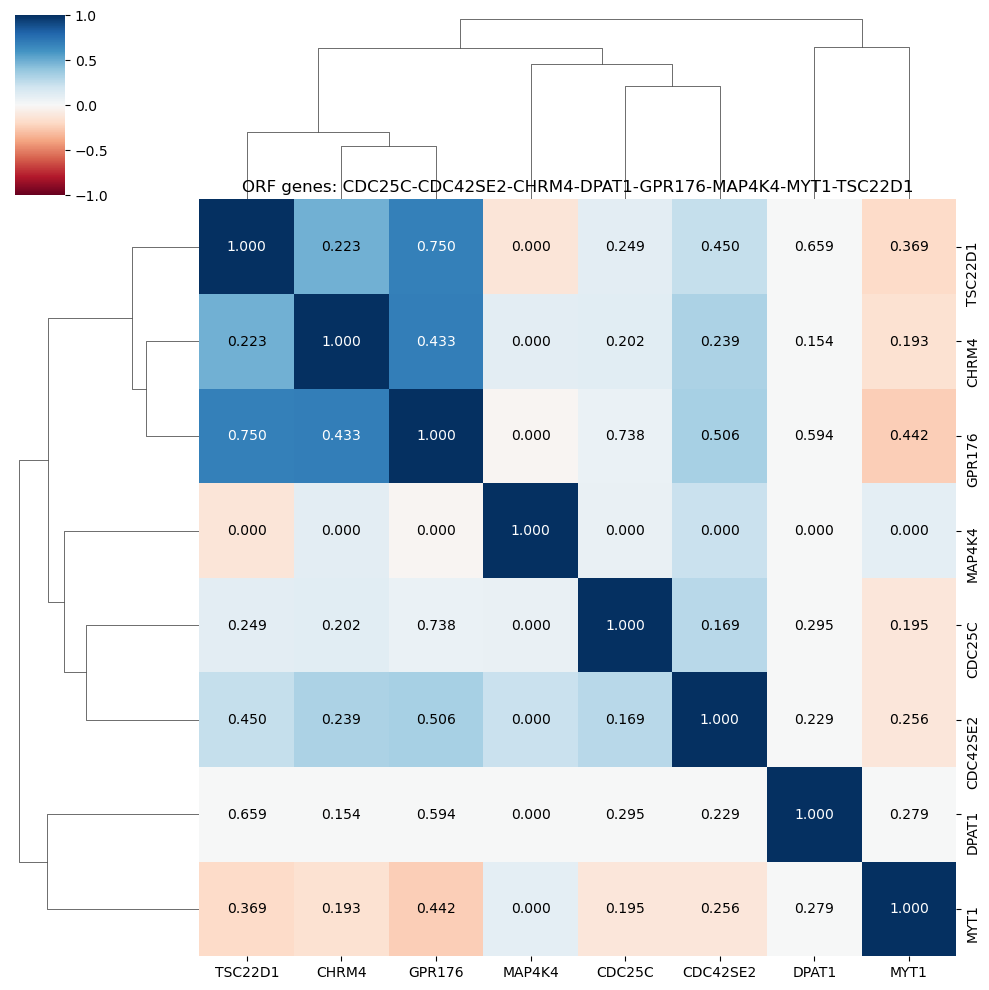

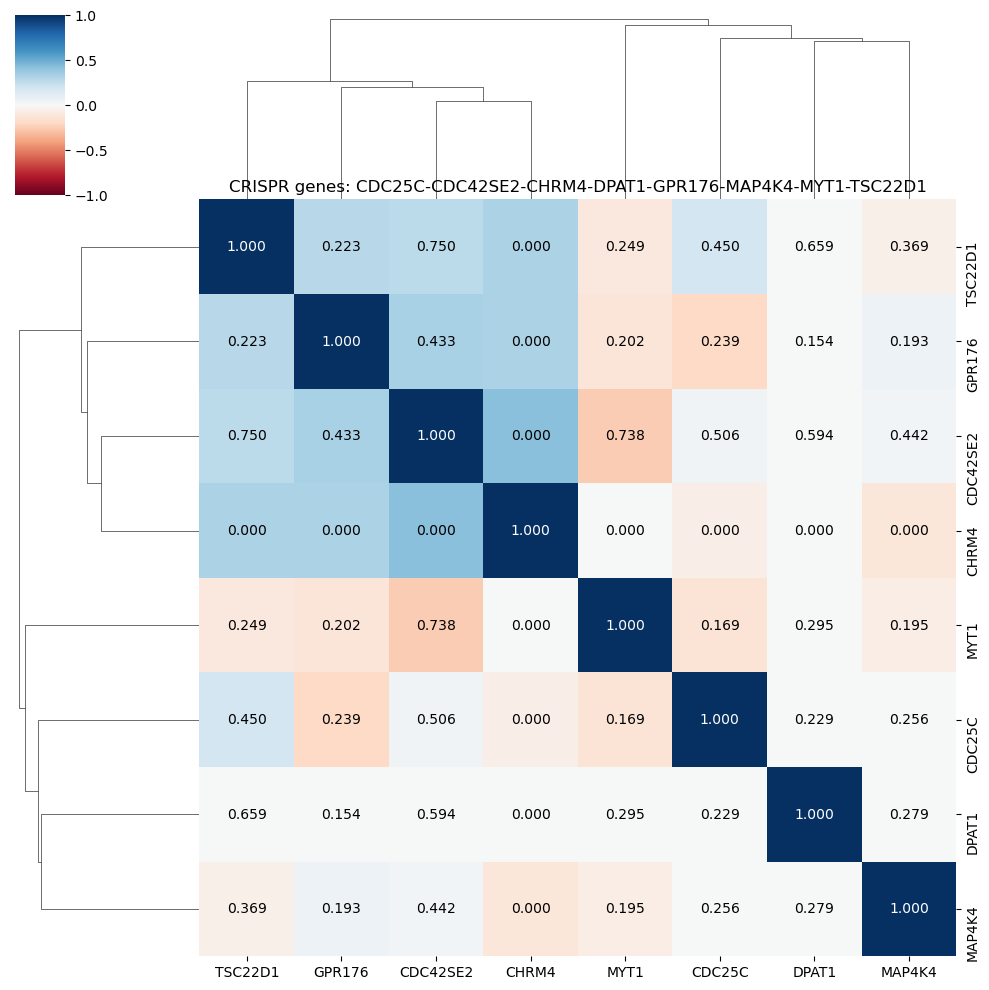

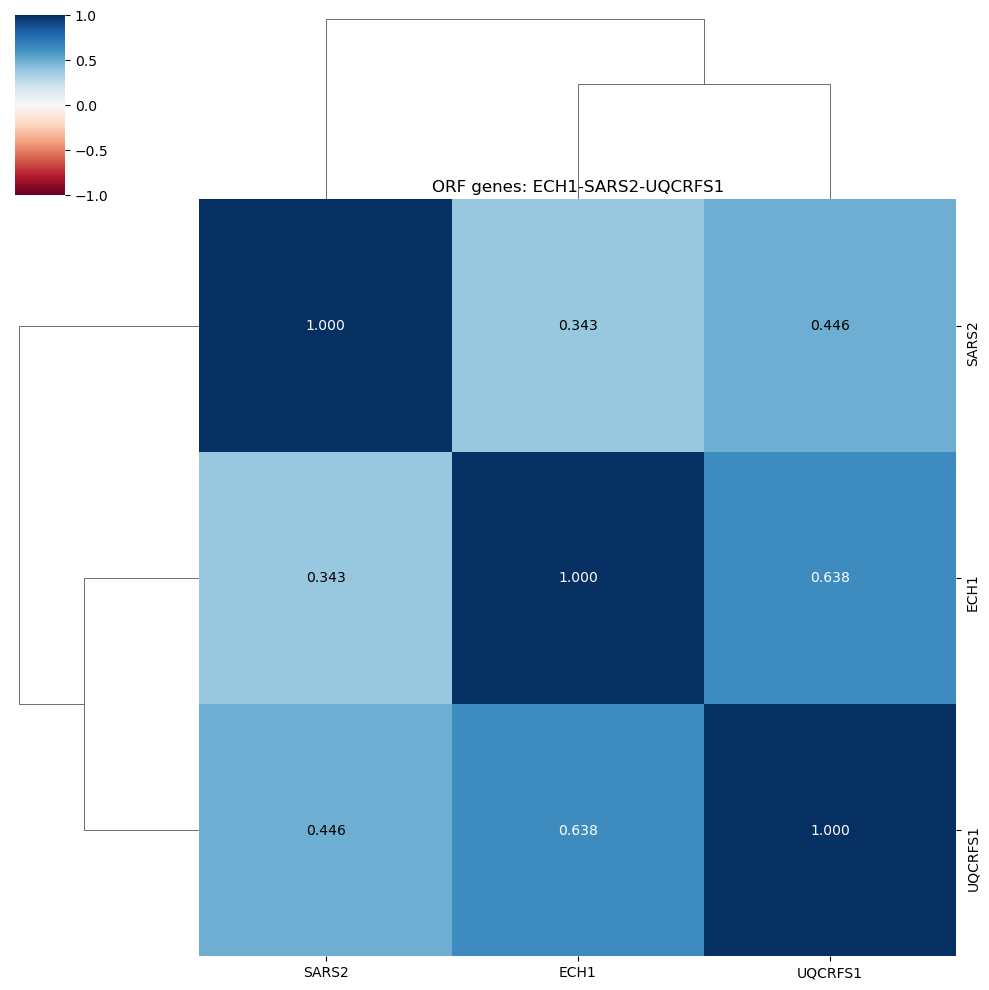

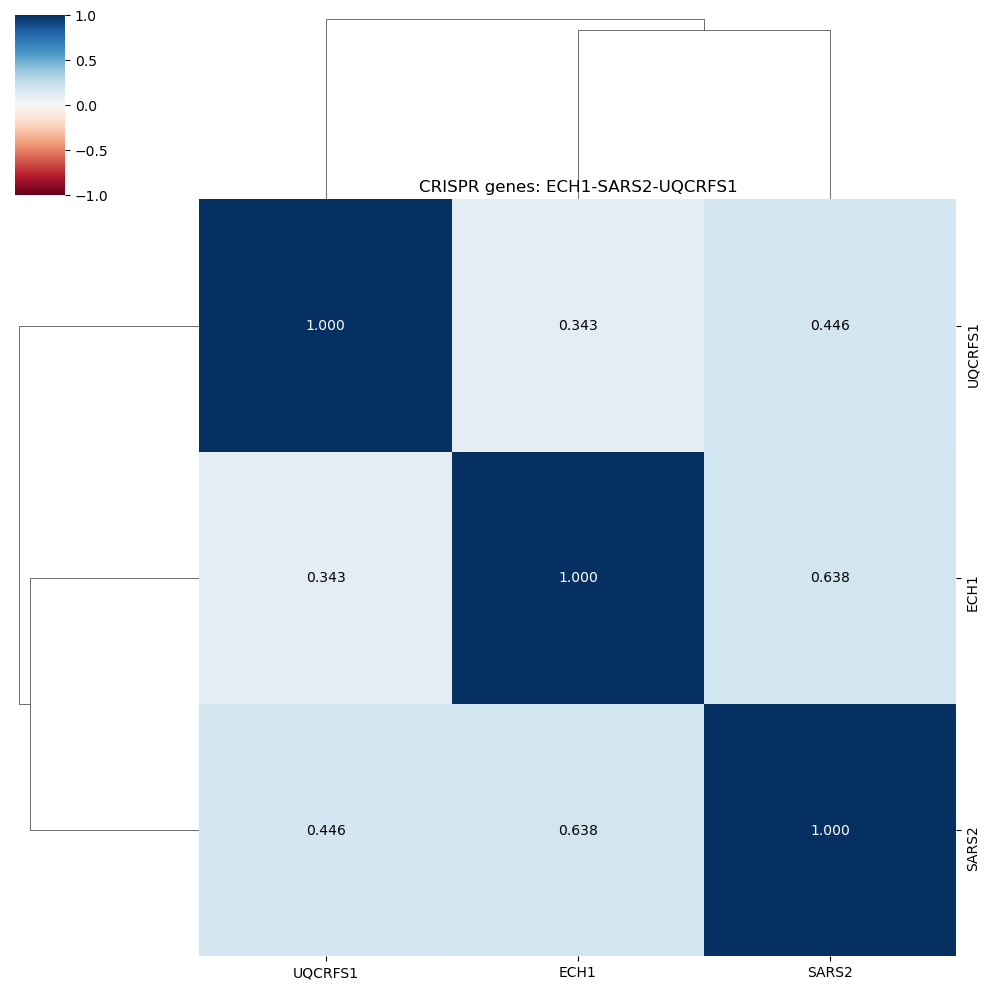

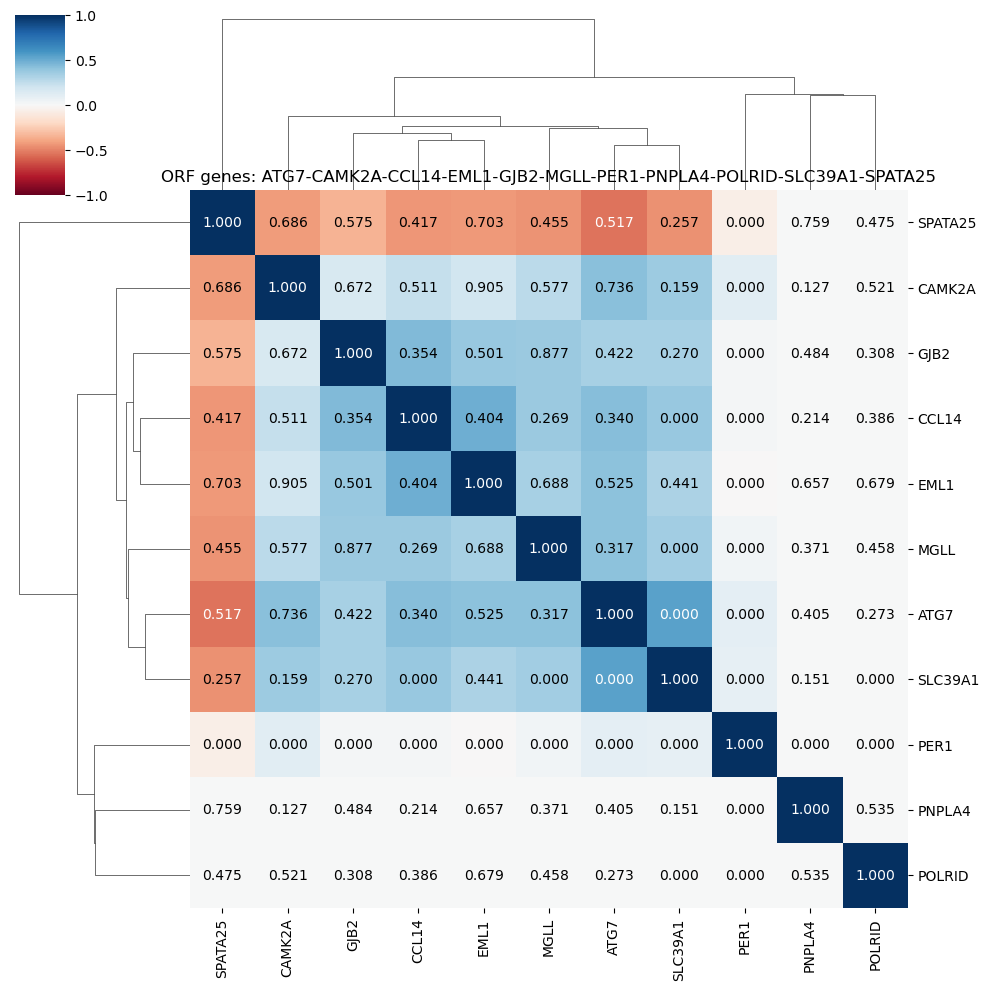

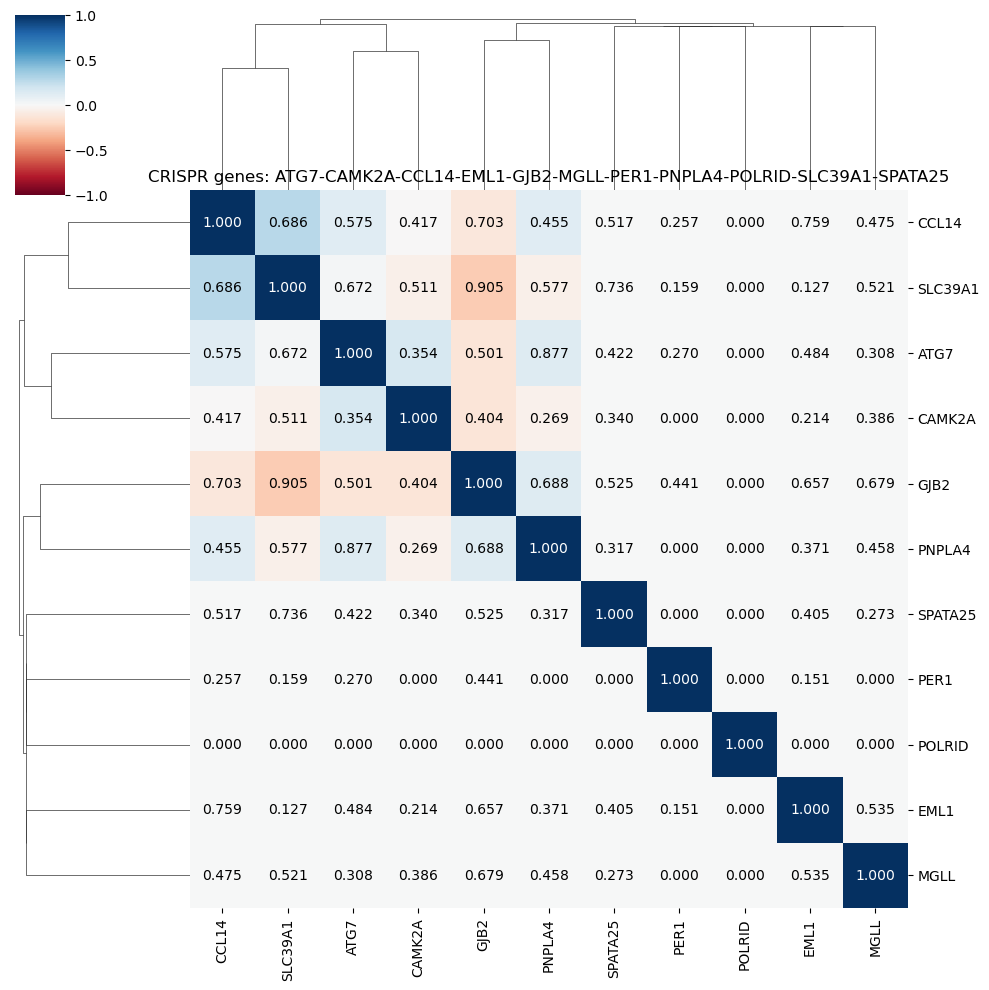

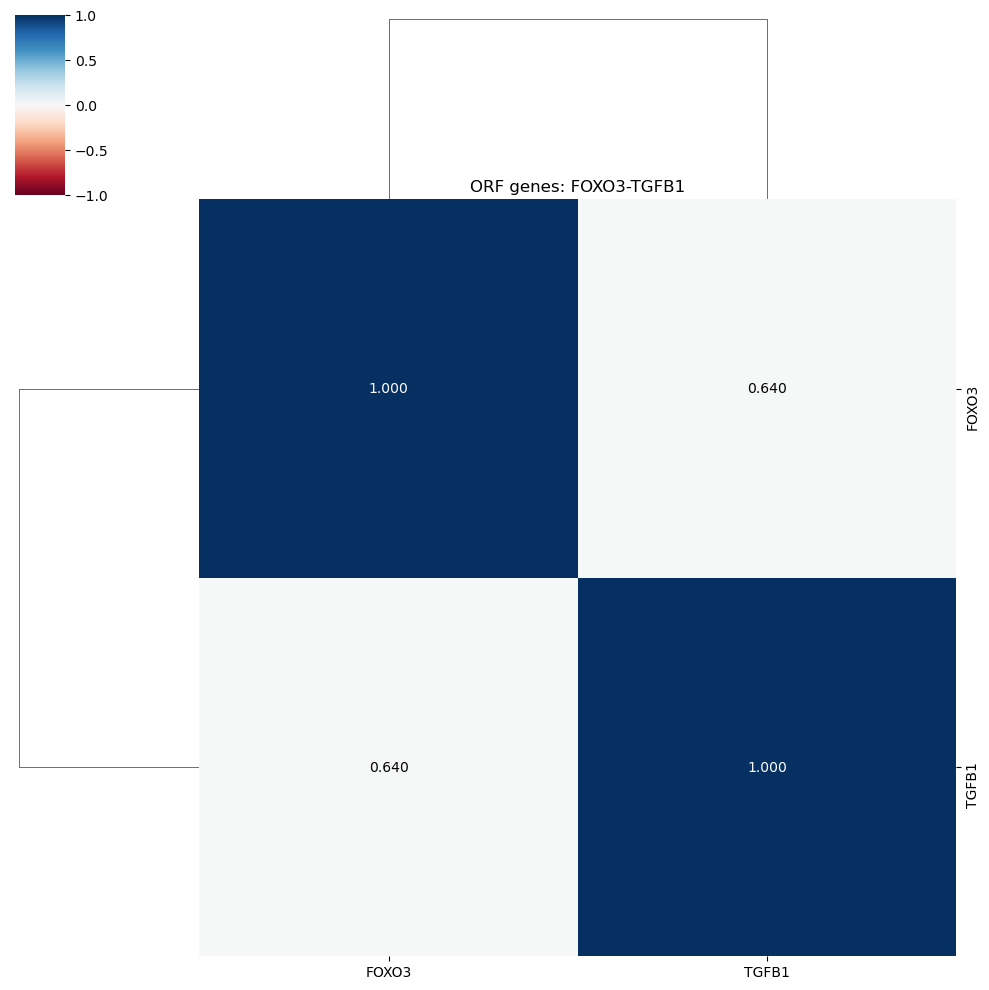

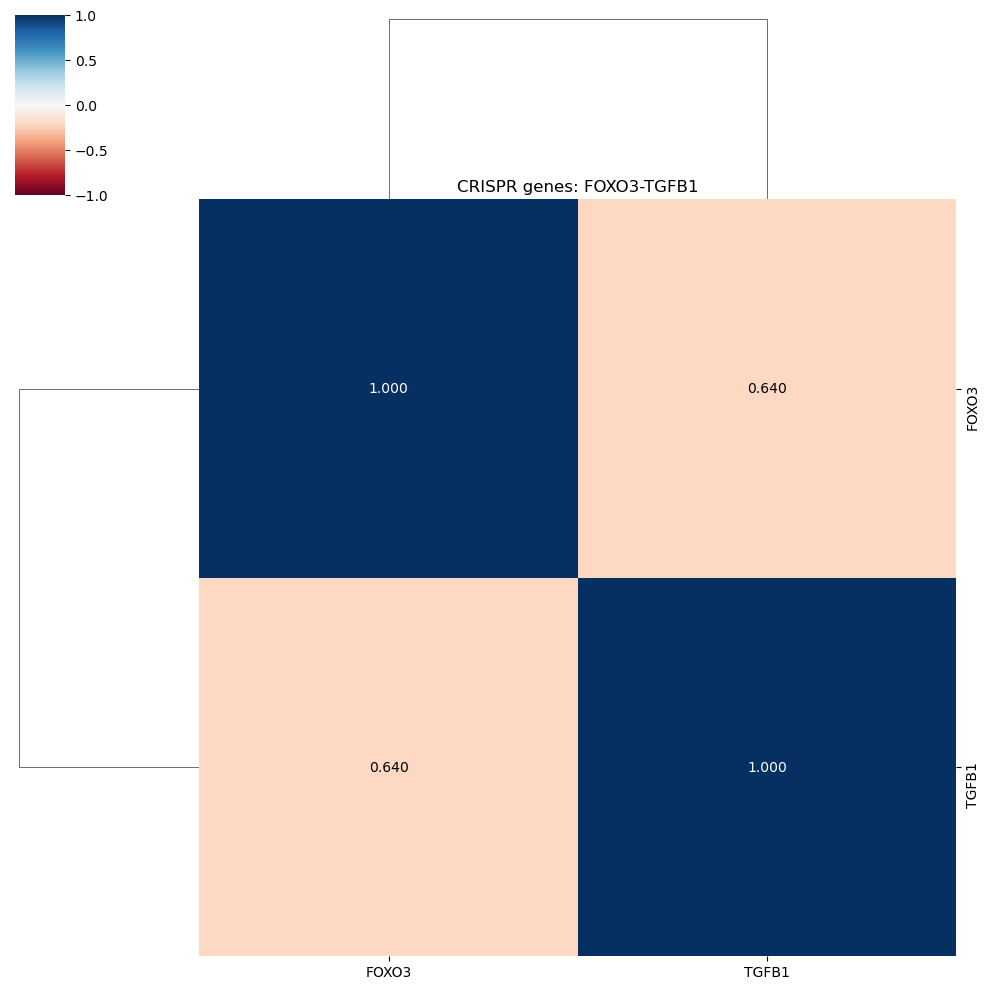

In [23]:
connections_trimmed_df = (
    connections_df[
        [
            "gene_1",
            "gene_2",
            "ORF_cosine_similarity",
            "CRISPR_cosine_similarity",
            "gene_mf",
            "gene_bp",
            "gene_pathway",
        ]
    ]
    .copy()
    .fillna(0)
    .assign(
        gene_kg=lambda x: np.max(
            x[["gene_mf", "gene_bp", "gene_pathway"]].abs(), axis=1
        )
    )
    .drop(columns=["gene_mf", "gene_bp", "gene_pathway"])
)

orf_col = ["gene_1", "gene_2", "ORF_cosine_similarity"]
crispr_col = ["gene_1", "gene_2", "CRISPR_cosine_similarity"]
kg_col = ["gene_1", "gene_2", "gene_kg"]

for genes in previous_gene_lists:
    genes.sort()
    gene_names = "-".join(genes)
    df = pd.DataFrame(
        list(itertools.combinations(genes, 2)), columns=["gene_1", "gene_2"]
    )
    plotting_df = df.merge(connections_trimmed_df, how="left", on=["gene_1", "gene_2"])
    plotting_df = pd.concat(
        [
            plotting_df,
            plotting_df.rename(columns={"gene_1": "gene_2", "gene_2": "gene_1"}),
        ],
        ignore_index=True,
    )
    orf_values = pd.pivot(
        plotting_df[orf_col],
        index="gene_1",
        columns="gene_2",
        values="ORF_cosine_similarity",
    ).values
    np.fill_diagonal(orf_values, 1)
    orf_df = pd.DataFrame(orf_values, columns=genes, index=genes)

    crispr_values = pd.pivot(
        plotting_df[crispr_col],
        index="gene_1",
        columns="gene_2",
        values="CRISPR_cosine_similarity",
    ).values
    np.fill_diagonal(crispr_values, 1)
    crispr_df = pd.DataFrame(crispr_values, columns=genes, index=genes)

    kg_values = pd.pivot(
        plotting_df[kg_col], index="gene_1", columns="gene_2", values="gene_kg"
    ).values
    np.fill_diagonal(kg_values, 1)
    kg_df = pd.DataFrame(kg_values, columns=genes, index=genes)

    g = sns.clustermap(
        orf_df,
        cmap="RdBu",
        vmin=-1,
        vmax=1,
    )

    g.ax_heatmap.set_title(f"ORF genes: {gene_names}")

    clustermap_df = g.data2d

    for i in range(len(kg_df)):
        for j in range(len(kg_df.columns)):
            text = f"{kg_df.values[i, j]:.3f}"
            x = j + 0.5  # Center the text horizontally
            y = i + 0.5  # Center the text vertically

            text_color = (
                "white"
                if clustermap_df.values[i, j] > 0.5 or clustermap_df.values[i, j] < -0.5
                else "black"
            )
            g.ax_heatmap.text(x, y, text, ha="center", va="center", color=text_color)
    
    plt.savefig(f"figures/ORF-connections-{gene_names}.png", dpi=300)
    plt.savefig(f"figures/ORF-connections-{gene_names}.svg", dpi=300)

    g = sns.clustermap(
        crispr_df,
        cmap="RdBu",
        vmin=-1,
        vmax=1,
    )
    g.ax_heatmap.set_title(f"CRISPR genes: {gene_names}")

    clustermap_df = g.data2d

    for i in range(len(kg_df)):
        for j in range(len(kg_df.columns)):
            text = f"{kg_df.values[i, j]:.3f}"
            x = j + 0.5  # Center the text horizontally
            y = i + 0.5  # Center the text vertically

            text_color = (
                "white"
                if clustermap_df.values[i, j] > 0.5 or clustermap_df.values[i, j] < -0.5
                else "black"
            )
            g.ax_heatmap.text(x, y, text, ha="center", va="center", color=text_color)

    plt.savefig(f"figures/CRISPR-connections-{gene_names}.png", dpi=300)
    plt.savefig(f"figures/CRISPR-connections-{gene_names}.svg", dpi=300)